In [3]:
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data.cc"

In [4]:
# !curl -L https://github.com/petewarden/magic_wand_digit_data/archive/8170591863f9addca27b1a963263f7c7bed33f41.zip -o magic_wand_digit_data.zip
# !unzip magic_wand_digit_data.zip
# !rm -rf magic_wand_digit_data
# !mv magic_wand_digit_data-* magic_wand_digit_data
# !rm -rf magic_wand_digit_data.zip
# !rm -rf sample_data
# !mkdir -p checkpoints

In [5]:
import glob
import json

strokes = []
for filename in glob.glob("Data/wanddata_*_original.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

In [6]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

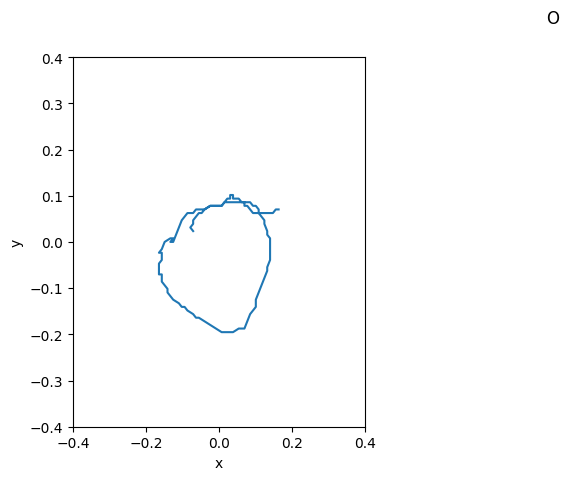

In [7]:
#for i in range(0, 900):
plot_stroke(strokes[1])

In [8]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

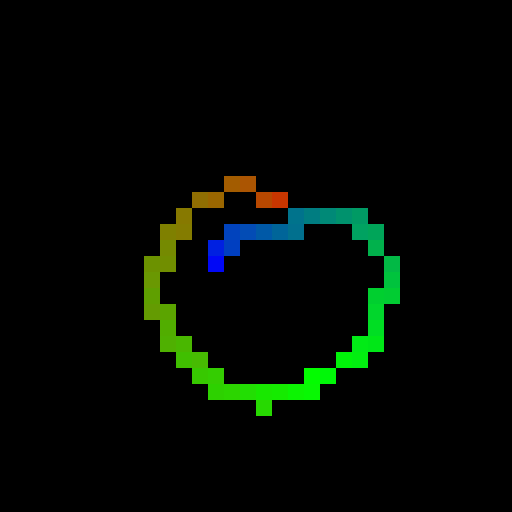

In [9]:

raster = rasterize_stroke(strokes[2]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [10]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [11]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [12]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 134 files belonging to 3 classes.
Found 11891 files belonging to 3 classes.


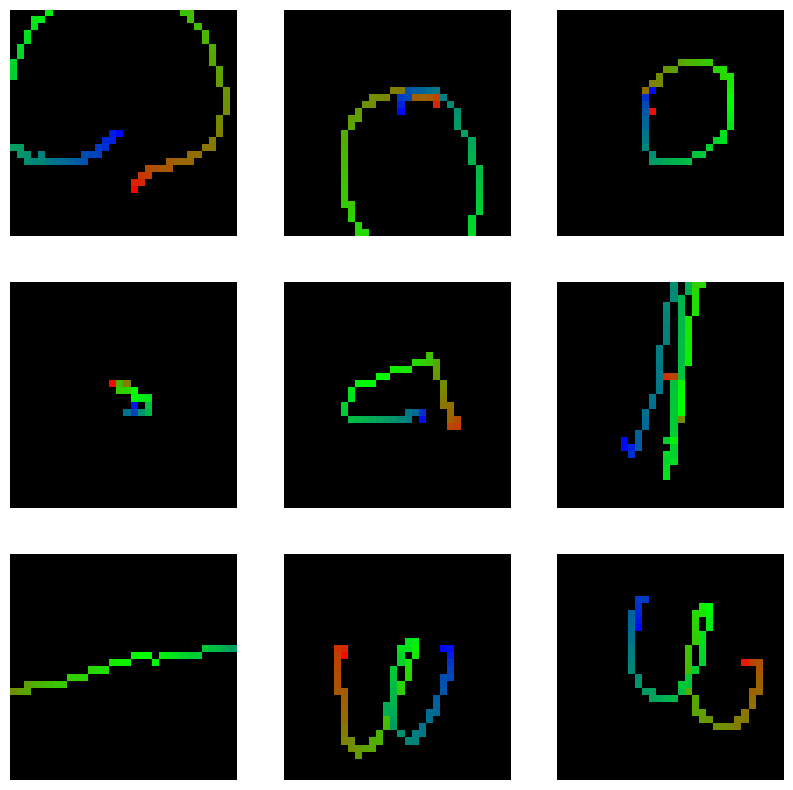

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [15]:
model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=3)
#keras.utils.plot_model(model, show_shapes=True)

(3,)


In [16]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.h5"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/30


369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5036 - loss: 0.6083

372/372 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.5663 - loss: 0.5537 - val_accuracy: 0.4104 - val_loss: 0.7010 - learning_rate: 0.0010
Epoch 2/30
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6576 - loss: 0.4677

372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6679 - loss: 0.4549 - val_accuracy: 0.6940 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7116 - loss: 0.4175

372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7143 - loss: 0.4125 - val_accuracy: 0.6493 - val_loss: 0.4326 - learning_rate: 0.0010
Epoch 4/30
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7270 - loss: 0.3959

372/372 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7332 - loss: 0.3897 - val_accuracy: 0.6866 - val_loss: 0.4176 - learning_rate: 0.0010
Epoch 5/30
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7348 - loss: 0.3871

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7385 - loss: 0.3825 - val_accuracy: 0.7537 - val_loss: 0.3741 - learning_rate: 0.0010
Epoch 6/30
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7444 - loss: 0.3740

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7517 - loss: 0.3699 - val_accuracy: 0.8284 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 7/30
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7619 - loss: 0.3643

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7618 - loss: 0.3628 - val_accuracy: 0.8134 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 8/30
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7593 - loss: 0.3637

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7655 - loss: 0.3569 - val_accuracy: 0.5821 - val_loss: 0.6196 - learning_rate: 0.0010
Epoch 9/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7791 - loss: 0.3485

372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7837 - loss: 0.3431 - val_accuracy: 0.6716 - val_loss: 0.4420 - learning_rate: 0.0010
Epoch 10/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7826 - loss: 0.3400

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7866 - loss: 0.3358 - val_accuracy: 0.8657 - val_loss: 0.2524 - learning_rate: 5.0000e-04
Epoch 11/30
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7832 - loss: 0.3358

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7890 - loss: 0.3337 - val_accuracy: 0.8507 - val_loss: 0.2692 - learning_rate: 5.0000e-04
Epoch 12/30
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7874 - loss: 0.3321

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7909 - loss: 0.3301 - val_accuracy: 0.8582 - val_loss: 0.2543 - learning_rate: 5.0000e-04
Epoch 13/30
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7861 - loss: 0.3304

372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7949 - loss: 0.3238 - val_accuracy: 0.8731 - val_loss: 0.2600 - learning_rate: 5.0000e-04
Epoch 14/30
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7937 - loss: 0.3310

372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7988 - loss: 0.3242 - val_accuracy: 0.8731 - val_loss: 0.2542 - learning_rate: 2.5000e-04
Epoch 15/30
368/372 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7922 - loss: 0.3272

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7995 - loss: 0.3216 - val_accuracy: 0.8657 - val_loss: 0.2416 - learning_rate: 2.5000e-04
Epoch 16/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7910 - loss: 0.3286

372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7960 - loss: 0.3243 - val_accuracy: 0.9104 - val_loss: 0.2263 - learning_rate: 2.5000e-04
Epoch 17/30
366/372 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8035 - loss: 0.3160

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8023 - loss: 0.3163 - val_accuracy: 0.8806 - val_loss: 0.2410 - learning_rate: 2.5000e-04
Epoch 18/30
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7965 - loss: 0.3169

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7985 - loss: 0.3149 - val_accuracy: 0.8657 - val_loss: 0.2291 - learning_rate: 2.5000e-04
Epoch 19/30
367/372 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7941 - loss: 0.3214

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7977 - loss: 0.3151 - val_accuracy: 0.8881 - val_loss: 0.2183 - learning_rate: 2.5000e-04
Epoch 20/30
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8018 - loss: 0.3166

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8073 - loss: 0.3122 - val_accuracy: 0.8358 - val_loss: 0.2445 - learning_rate: 2.5000e-04
Epoch 21/30
365/372 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8020 - loss: 0.3175

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8030 - loss: 0.3163 - val_accuracy: 0.8657 - val_loss: 0.2276 - learning_rate: 2.5000e-04
Epoch 22/30
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8082 - loss: 0.3117

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8112 - loss: 0.3055 - val_accuracy: 0.8881 - val_loss: 0.2250 - learning_rate: 2.5000e-04
Epoch 23/30
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8094 - loss: 0.3035

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8104 - loss: 0.3042 - val_accuracy: 0.8955 - val_loss: 0.2114 - learning_rate: 1.2500e-04
Epoch 24/30
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8078 - loss: 0.3075

372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8104 - loss: 0.3058 - val_accuracy: 0.8881 - val_loss: 0.2140 - learning_rate: 1.2500e-04
Epoch 25/30
368/372 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8092 - loss: 0.3121

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8101 - loss: 0.3082 - val_accuracy: 0.8955 - val_loss: 0.2186 - learning_rate: 1.2500e-04
Epoch 26/30
367/372 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8121 - loss: 0.3061

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8171 - loss: 0.3021 - val_accuracy: 0.8955 - val_loss: 0.2187 - learning_rate: 1.2500e-04
Epoch 27/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8129 - loss: 0.3063

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8125 - loss: 0.3049 - val_accuracy: 0.8881 - val_loss: 0.2128 - learning_rate: 6.2500e-05
Epoch 28/30
367/372 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8082 - loss: 0.3086

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8098 - loss: 0.3032 - val_accuracy: 0.8955 - val_loss: 0.2109 - learning_rate: 6.2500e-05
Epoch 29/30
367/372 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8109 - loss: 0.3041

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8130 - loss: 0.3017 - val_accuracy: 0.8955 - val_loss: 0.2128 - learning_rate: 6.2500e-05
Epoch 30/30
366/372 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8113 - loss: 0.3054

372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8137 - loss: 0.3052 - val_accuracy: 0.8955 - val_loss: 0.2123 - learning_rate: 6.2500e-05


In [17]:
def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)
  
index, score = predict_image(model, "test/o/4.png")

print(index, score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1 0.68527514


In [18]:
from IPython.display import Image, display

SCORE_THRESHOLD = 0.7

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
  label = (label_dir.replace("test/", ""))
  if(label == 'test\\n'):
    label = 0
  if(label == 'test\\w'):
    label = 2
  if(label == 'test\\o'):
    label = 1
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
      continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      # print("%s expected, %d found with score %f" % (label, index, score))
      # display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [19]:
from tinymlgen import port

c_code = port(model, variable_name='spell_model', pretty_print=True,optimize=False)
filename = 'net.h'
with open(filename,'w') as f: 
   f.write(c_code)

INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpq7rdhfv8\assets


INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpq7rdhfv8\assets


Saved artifact at 'C:\Users\hugo-\AppData\Local\Temp\tmpq7rdhfv8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2647098524496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098539280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098525456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098524304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098524688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098525648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098

In [20]:
model.save(SAVED_MODEL_FILENAME+".h5")

In [21]:
#!curl -L https://storage.googleapis.com/download.tensorflow.org/models/tflite/micro/magic_wand_saved_model_2021_01_02.tgz -o saved_model.tgz
#!tar -xzf saved_model.tgz

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpn2813kay\assets


INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpn2813kay\assets


Saved artifact at 'C:\Users\hugo-\AppData\Local\Temp\tmpn2813kay'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2647098524496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098539280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098525456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098524304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098524688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098525648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098

INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmp_lwkzwwl\assets


Saved artifact at 'C:\Users\hugo-\AppData\Local\Temp\tmp_lwkzwwl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2647098524496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098539280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098525456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098524304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098524688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098525648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098526032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647098

c:\Users\hugo-\anaconda3\envs\test2_tut0\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


30920

In [23]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  
  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [24]:
predict_tflite(model_no_quant_tflite, "test/o/2.png")

c:\Users\hugo-\anaconda3\envs\test2_tut0\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


(np.int64(1), np.float32(0.9921096))

In [25]:
predict_tflite(model_tflite, "test/o/2.png")

(np.int64(1), np.float32(0.99609375))

In [26]:
from IPython.display import Image, display

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
  label = (label_dir.replace("test/", ""))
  if(label == 'test\\n'):
    label = 0
  if(label == 'test\\w'):
    label = 2
  if(label == 'test\\o'):
    label = 1
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_tflite(model_tflite, filename)
    if score < 0.75:
      discarded_count += 1
      continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      #print("%d expected, %d found with score %f" % (label, index, score))
      #display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

89.2% correct (N=1264, 210 unknown)


In [ ]:
import os
import pandas as pd

def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME+".h5")
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


FileNotFoundError: [WinError 3] Det går inte att hitta sökvägen: 'saved_modelh5'

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15

In [ ]:
# Print the C source file
!tail {TFL_CC_MODEL_FILENAME}

  0x04, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xd0, 0xff, 0xff, 0xff,
  0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x19,
  0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28, 0x0c, 0x00, 0x10, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_data_len = 30912;


In [ ]:
# import csv

# labells = []

# csvfile_r = open("Data/O_first_last.csv")
# csvreader_r = csv.reader(csvfile_r)
# for row in csvreader_r:
#     labells.append(row[1])

# labells.remove("last")
# csvfile_r.close()
        
# i = 0

# rows = []



# csvfile_w = open("Data/O_body_padded.csv", "r")
# csvreader_w = csv.reader(csvfile_w)
# for row in csvreader_w:
#     rows_m = []
#     for item in row:
#         rows_m.append(item)
#     rows_m.append(labells[i])
#     i += 1
#     rows.append(rows_m)

# csvfile_w.close()

# with open('Data/O_body_padded_labels.csv', 'w', newline='') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     for row in rows:
#         spamwriter.writerow(row)
